In [326]:

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import numpy as np 
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [331]:
path = '../input/the-oxfordiiit-pet-dataset/images/images/'
train_data = [(str(img), '_'.join(str(img).split('/')[-1].split('_')[:-1])) for img in glob.glob(path + '*.jpg')]
train_data = pd.DataFrame(train_data, columns=['filename', 'label'])
train, test = train_test_split(train_data, test_size=0.2)
n_labels = train_data['label'].nunique()

In [332]:
n_labels

37

In [333]:
train.head()

,filename,label
3014,../input/the-oxfordiiit-pet-dataset/images/ima...,staffordshire_bull_terrier
6651,../input/the-oxfordiiit-pet-dataset/images/ima...,pomeranian
3637,../input/the-oxfordiiit-pet-dataset/images/ima...,samoyed
1302,../input/the-oxfordiiit-pet-dataset/images/ima...,staffordshire_bull_terrier
7133,../input/the-oxfordiiit-pet-dataset/images/ima...,Ragdoll


In [334]:
IMAGE_SIZE = 224
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
BATCH_SIZE = 32


data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = data_generator.flow_from_dataframe(dataframe = train, x_col = "filename",
                                                    y_col = "label", target_size = (IMAGE_SIZE, 
                                                                                    IMAGE_SIZE),
                                                    batch_size = BATCH_SIZE, 
                                                    class_mode = 'categorical')


val_generator = data_generator.flow_from_dataframe(dataframe = test, x_col = "filename",
                                                 y_col = "label", target_size = (IMAGE_SIZE, 
                                                                                 IMAGE_SIZE),
                                                 batch_size = BATCH_SIZE, 
                                                 class_mode = 'categorical', 
                                                 shuffle = False)



input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)
model = Sequential()

model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.layers[0].trainable = False

model.add(Dense(n_labels))
model.add(Activation('sigmoid'))
    
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

steps_train = np.ceil(train.shape[0]/BATCH_SIZE)
steps_val = np.ceil(test.shape[0]/BATCH_SIZE)


# model.fit_generator(train_generator, steps_per_epoch = steps_train, validation_data = val_generator, epochs = 20, validation_steps = steps_val, verbose = 1)

Found 5912 validated image filenames belonging to 37 classes.
Found 1478 validated image filenames belonging to 37 classes.


In [335]:
# model.save_weights("model.h5")
model.load_weights("../input/cats-classifer/model.h5")

In [336]:
model.evaluate_generator(val_generator, steps_val)

[0.012068876065313816, 0.9594045877456665]

In [339]:
predictions=model.predict_generator(val_generator, verbose=1)
test_labels = val_generator.classes
y_pred = np.argmax(predictions, axis=-1)
print(classification_report(test_labels, y_pred))

47/47 [==============================] - 9s 188ms/step
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        48
           1       0.95      0.95      0.95        39
           2       0.97      0.93      0.95        41
           3       0.98      1.00      0.99        42
           4       0.93      1.00      0.97        42
           5       0.97      0.95      0.96        38
           6       0.98      0.95      0.97        44
           7       0.96      0.98      0.97        44
           8       0.85      0.97      0.91        35
           9       1.00      0.87      0.93        39
          10       0.98      0.95      0.96        43
          11       1.00      1.00      1.00        37
          12       0.89      0.94      0.92        36
          13       0.86      0.86      0.86        37
          14       0.96      0.94      0.95        48
          15       0.92      0.85      0.88        27
          16       0.98   

In [340]:
weights_path = '../input/yolo-coco-data/yolov3.weights'
configuration_path = '../input/yolo-coco-data/yolov3.cfg'

probability_minimum = 0.98

In [341]:
network = cv2.dnn.readNetFromDarknet(configuration_path, weights_path)

layers_names_all = network.getLayerNames()

layers_names_output = [layers_names_all[i[0] - 1] for i in network.getUnconnectedOutLayers()]


In [343]:
def class_from_number(n):
    return np.sort(train_data['label'].unique())[n]

In [344]:
def crop_and_classify(filename):
    img = cv2.imread(filename)
    img_shape = img.shape
    blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    network.setInput(blob)
    output_from_network = network.forward(layers_names_output)
    
    bounding_boxes = []
    confidences = []
    class_numbers = []
    h = img_shape[0]
    w = img_shape[1]
    threshold = 0.3
    labels = ['cat']
    colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')



    for result in output_from_network:
        for detection in result:
            scores = detection[5:]
            class_current = np.argmax(scores)

            confidence_current = scores[class_current]

            if confidence_current > probability_minimum:

                box_current = detection[0:4] * np.array([w, h, w, h])


                x_center, y_center, box_width, box_height = box_current.astype('int')
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)
                
    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)
    
    if len(results) > 0:
        cropped_creatures = []
        for i in results.flatten():
                x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
                box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
                cropped_creatures.append([x_min, y_min, box_width, box_height])


                
    colour_box_current = (0, 0, 255)           
    imgs_to_classify = [img[coor[1]:coor[1]+coor[3], coor[0]:coor[0]+coor[2]]  for coor in cropped_creatures]
    
    for i in range(len(imgs_to_classify)):
        imgs_to_classify[i] = cv2.cvtColor(imgs_to_classify[i], cv2.COLOR_BGR2RGB)
        imgs_to_classify[i] = cv2.resize(imgs_to_classify[i], (224, 224))
        
    input_img = np.array([preprocess_input(i) for i in imgs_to_classify])

    preds = model.predict(input_img)
        
    for i, cr in enumerate(cropped_creatures):
        
        cv2.rectangle(img, (cr[0], cr[1]), (cr[0] + cr[2], cr[1] + cr[3]),
                              colour_box_current, 1)
        cv2.putText(img, class_from_number(np.argmax(preds[i])), (cr[0], cr[1]), cv2.FONT_HERSHEY_SIMPLEX,
                            1.5, colour_box_current, 2)
    
    %matplotlib inline
    plt.rcParams['figure.figsize'] = (10.0, 10.0)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

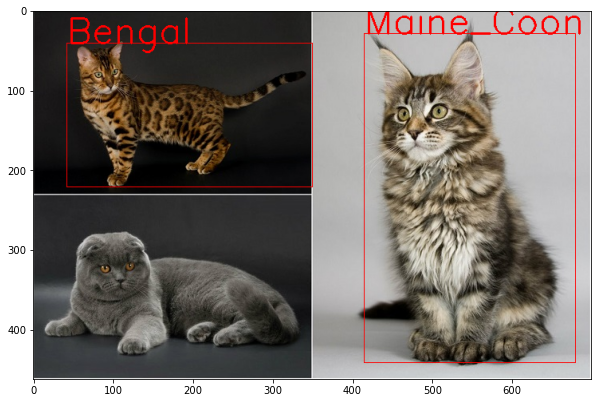

In [345]:
crop_and_classify('../input/cats-classifer/8.jpg')

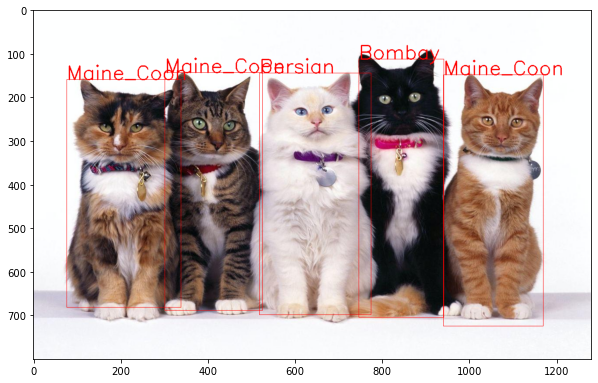

In [346]:
crop_and_classify('../input/cats-classifer/1.jpg')

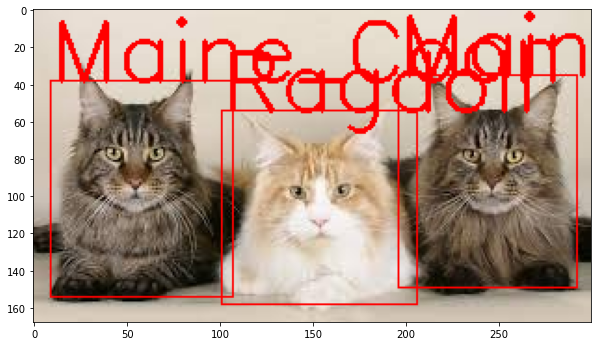

In [347]:
crop_and_classify('../input/cats-classifer/6.jpg')